In [4]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Trabajo Practico 1

Configuracion común:

In [5]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Pasos

#### A) A partir de los datos entregados, describir los atributos realizando una breve explicación de qué representan y del tipo de variable (categórica, numérica u ordinal). En caso de que haya variables no numéricas, reportar los posibles valores que toman y cuán frecuentemente lo hacen.

In [6]:
dataset = pd.read_csv('../dataset/healthcare-dataset-stroke-data.csv')

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#### Genero

Es una variable categorica con los siguentes posibles valores:

In [8]:
dataset.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

<AxesSubplot:xlabel='gender', ylabel='Count'>

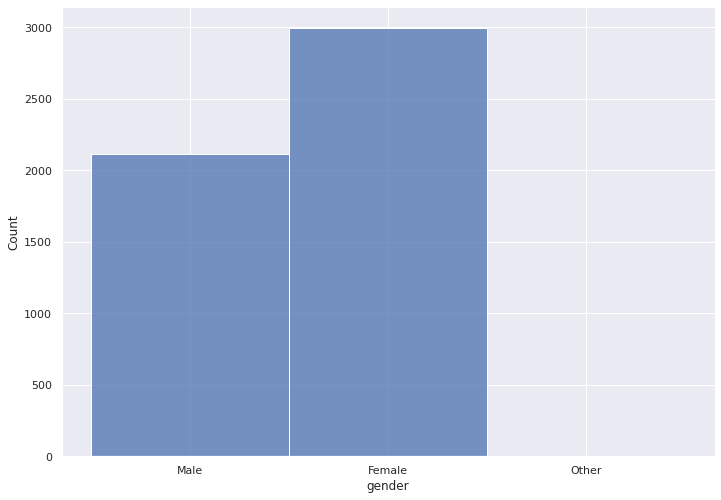

In [9]:
sns.histplot(data=dataset, x="gender")

In [10]:
dataset['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

#### Edad

Es una variable ordinal categorica:

<AxesSubplot:xlabel='age', ylabel='Count'>

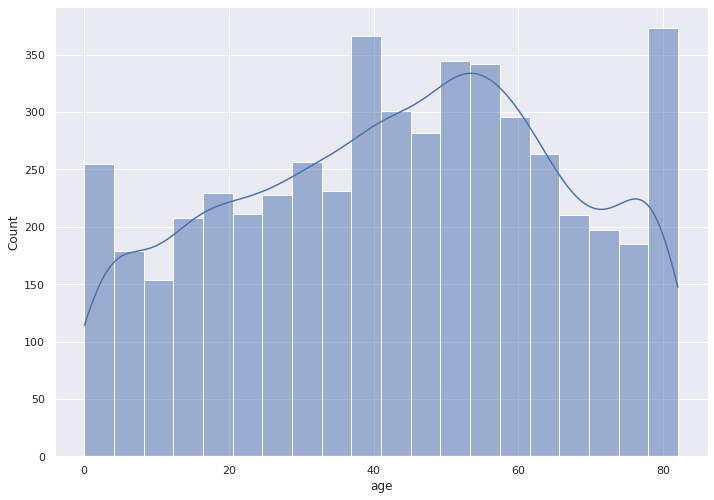

In [11]:
sns.histplot(data=dataset, x='age', kde=True)

In [12]:
dataset['age'].value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
0.48       3
1.40       3
0.16       3
0.08       2
0.40       2
Name: age, Length: 104, dtype: int64

#### Hypertension

Indica si el paciente tiene hipertension o no. Es una variable categorica con los siguentes posibles valores:

In [13]:
dataset['hypertension'].unique()

array([0, 1])

<AxesSubplot:xlabel='Count', ylabel='hypertension'>

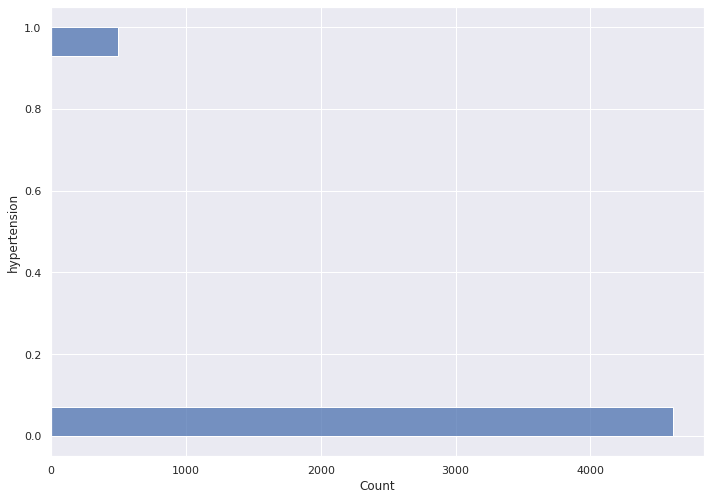

In [14]:
sns.histplot(data=dataset, y='hypertension')

In [15]:
dataset['hypertension'].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

#### Heart Disease

Explica si el individio tiene una enfermedad cardiaca o no. Es una variable categorica con los siguentes posibles valores:

In [16]:
dataset['hypertension'].unique()

array([0, 1])

<AxesSubplot:xlabel='Count', ylabel='heart_disease'>

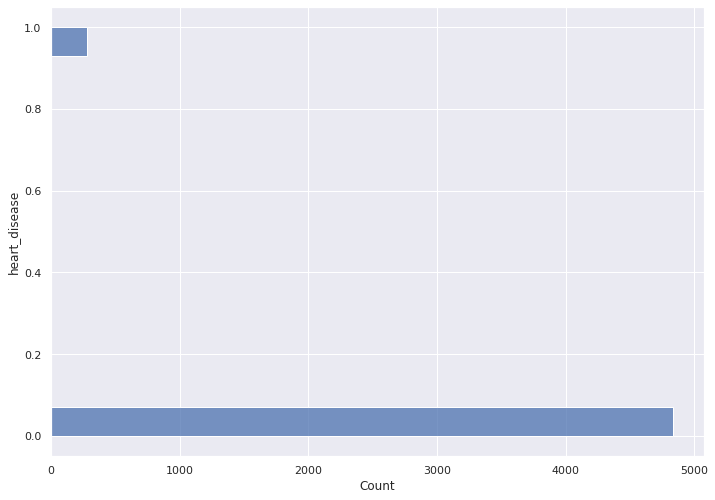

In [17]:
sns.histplot(data=dataset, y='heart_disease')

In [18]:
dataset['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

#### Ever Married

El individuo estuvo o esta casado?. Es una variable categorica con los siguentes posibles valores:

In [19]:
dataset['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

<AxesSubplot:xlabel='ever_married', ylabel='Count'>

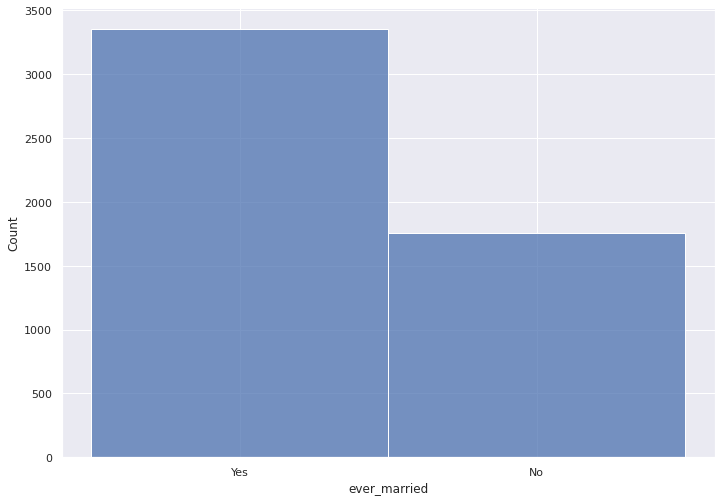

In [20]:
sns.histplot(data=dataset, x='ever_married')

In [21]:
dataset['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

#### Work Type

Tipo de trabajo. Es una variable categorica con los siguentes posibles valores:

In [22]:
dataset['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

<AxesSubplot:xlabel='Count', ylabel='work_type'>

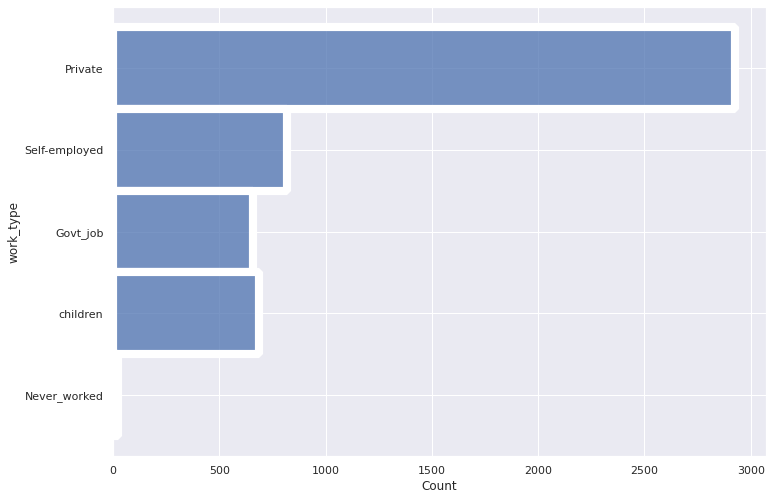

In [23]:
sns.histplot(data=dataset, y='work_type')

In [24]:
dataset['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

#### Residence type

Tipo de zona donde reside el invididuo. Es una variable categorica con los siguentes posibles valores:

In [25]:
dataset['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

<AxesSubplot:xlabel='Residence_type', ylabel='Count'>

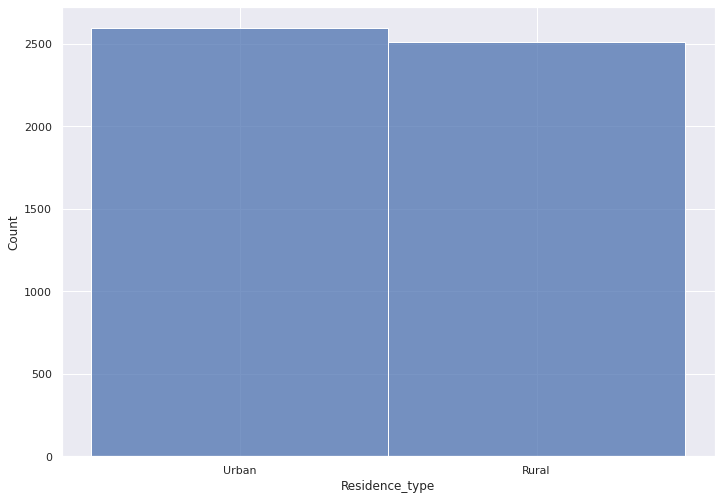

In [26]:
sns.histplot(data=dataset, x='Residence_type')

In [27]:
dataset['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

#### AVG Glucose Level

Nivel de grucosa medio el individuo. Es una variable numerica.

In [28]:
dataset['avg_glucose_level'].unique()

array([228.69, 202.21, 105.92, ...,  82.99, 166.29,  85.28])

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

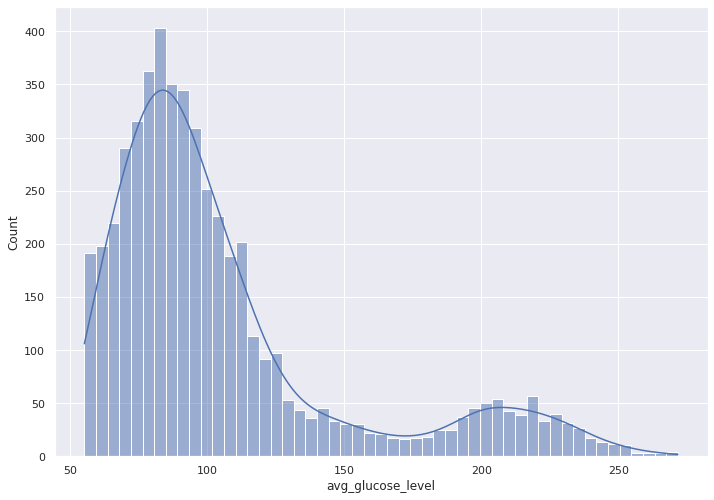

In [29]:
sns.histplot(data=dataset, x='avg_glucose_level', kde=True)

#### BMI

Es una variable numerica. No logro determinar a que se refiere.

<AxesSubplot:xlabel='bmi', ylabel='Count'>

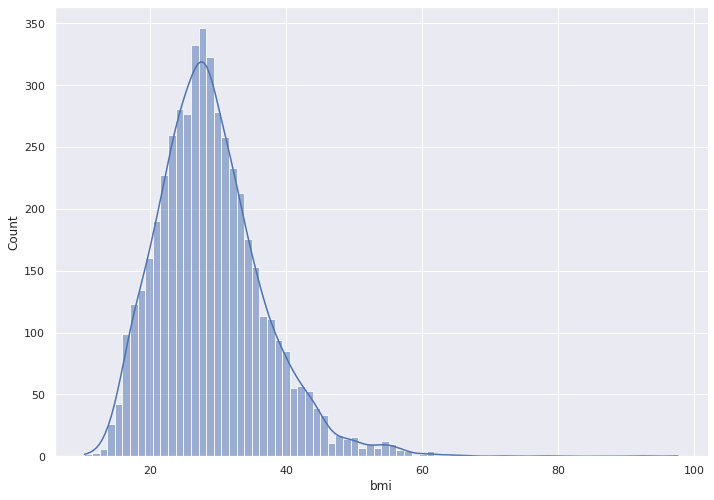

In [30]:
sns.histplot(data=dataset, x='bmi', kde= True)

#### Smoking Status

Se refiere al nivel de fumador al que perteneces el individuo. Es una variable categorica con los siguentes posibles valores:

In [31]:
dataset['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

<AxesSubplot:xlabel='Count', ylabel='smoking_status'>

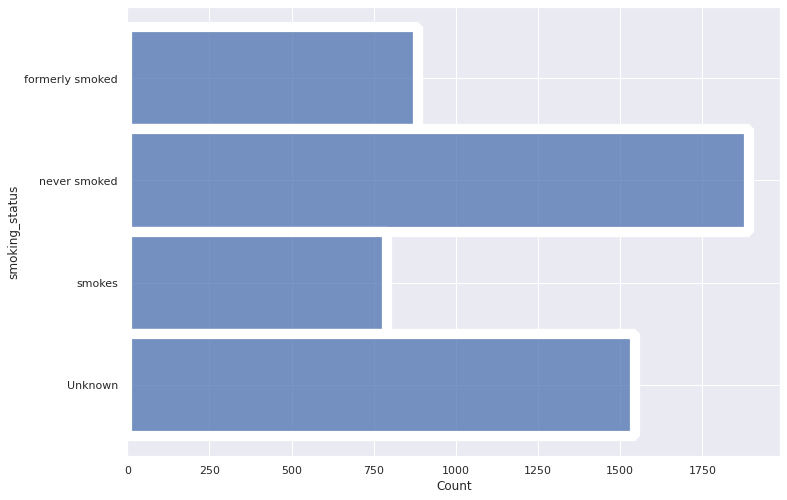

In [32]:
sns.histplot(data=dataset, y='smoking_status')

In [33]:
dataset['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

#### Stroke

Informa si el individuo sufrio un derrame cerebral o no. Es una variable categorica con los siguentes posibles valores:

In [34]:
dataset['stroke'].unique()

array([1, 0])

<AxesSubplot:xlabel='Count', ylabel='stroke'>

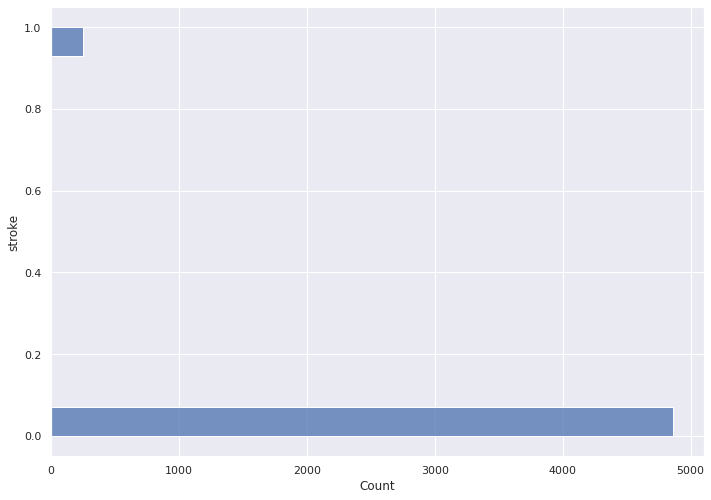

In [35]:
sns.histplot(data=dataset, y='stroke')

In [36]:
dataset['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

#### b) Reportar si hay valores faltantes. ¿Cuántos son y en qué atributos se encuentran? En caso de haberlos, ¿es necesario y posible asignarles un valor?

#### Valores faltantes por columna

In [37]:
incomplete_percent = dataset.isnull().sum() * 100 / len(dataset)
incomplete_percent[incomplete_percent > 0]

bmi    3.933464
dtype: float64

La unica variable que tiene valores incompletos es BMI y es un 4%.

In [38]:
numeric_columns = dataset.select_dtypes(include=np.number)
numeric_columns = numeric_columns.drop('id', axis=1)
numeric_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                5110 non-null   float64
 1   hypertension       5110 non-null   int64  
 2   heart_disease      5110 non-null   int64  
 3   avg_glucose_level  5110 non-null   float64
 4   bmi                4909 non-null   float64
 5   stroke             5110 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 239.7 KB


Completamos los faltante y comparamos la distribucion de la columna BMI antes y despues de la imputacion:

<AxesSubplot:xlabel='bmi', ylabel='Density'>

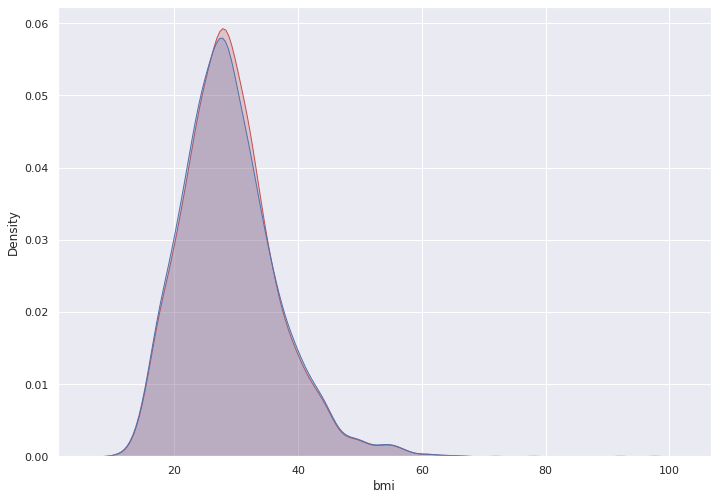

In [39]:
imputer = IterativeImputer()
imputer.fit(numeric_columns)

impl_numeric_columns = imputer.fit_transform(numeric_columns)

impl_numeric_columns = pd.DataFrame(
    data=impl_numeric_columns, 
    columns=numeric_columns.columns
)

sns.kdeplot(impl_numeric_columns['bmi'], shade=True, color="r")
sns.kdeplot(dataset['bmi'], shade=True, color="b")

In [40]:
impl_numeric_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                5110 non-null   float64
 1   hypertension       5110 non-null   float64
 2   heart_disease      5110 non-null   float64
 3   avg_glucose_level  5110 non-null   float64
 4   bmi                5110 non-null   float64
 5   stroke             5110 non-null   float64
dtypes: float64(6)
memory usage: 239.7 KB


Ahora la columna BMI esta completa.

#### c) ¿Qué variables se correlacionan más con el evento de lesión (Stroke)? Para las cuatro más correlacionadas, realizar un gráfico en el que se pueda observar la correlación entre la variable y el stroke.

Completar!

#### d) Se necesita saber cuáles son los indicadores que determinan más susceptibilidad a sufrir una lesión. ¿Qué atributos utilizará como variables predictoras? ¿Por qué?

Completar!

#### e) ¿Se encuentra balanceado el conjunto de datos que utilizará para desarrollar el algoritmo diseñado para contestar el punto d)? En base a lo respondido, ¿qué métricas de performance reportaría y por qué? En caso de estar desbalanceado, ¿qué estrategia de balanceo utilizaría?

Completar!

#### f) Suponiendo que es más importante detectar los casos en donde el evento ocurre. ¿Qué medida de performance utilizaría? Si utiliza Fβ-Score, ¿qué valor de β eligiría?

Completar!

#### g) Implementar el algoritmo introducido en el punto d) utilizando árboles de decisión. En primer lugar, se deberá separar un 20% de los datos para usarlos como conjunto de evaluación (test set). El conjunto restante (80%) es el de desarrollo y es con el que se deberá continuar haciendo el trabajo. Realizar los siguientes puntos

Completar!

#### g.1) Armar conjuntos de entrenamiento y validación con proporción 80-20 del conjunto de desarrollo de forma aleatoria. Usar 50 semillas distintas y realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en c) en esas 50 particiones distintas.

Completar!

#### g.2) Usar validación cruzada de 50 iteraciones (50-fold cross validation). Realizar un gráfico de caja y bigotes que muestre cómo varía la métrica elegida en esas 50 particiones distintas.

Completar!

#### h) Graficar el árbol de decisión con mejor performance encontrado en el punto g2). Analizar el árbol de decisión armado (atributos elegidos y decisiones evaluadas).

Completar!

#### i) Usando validación cruzada de 10 iteraciones (10-fold cross validation), probar distintos valores de α del algoritmo de poda mínima de complejidad de costos (algoritmo de poda de sklearn). Hacer gráficos de la performance en validación y entrenamiento en función del α. Explicar cómo varía la profundidad de los árboles al realizar la poda con distintos valores de α.

Completar!

#### j) Evaluar en el conjunto de evaluación, el árbol correspondiente al α que maximice la performance en el conjunto de validación. Comparar con el caso sin poda (α=0)

Completar!

#### k) Para el árbol sin poda, obtener la importancia de los descriptores usando la técnica de eliminación recursiva. Reentrenar el árbol usando sólo los 3 descriptores más importantes. Comparar la performance en el conjunto de prueba.

Completar!